# Calculate Prior Probability of Edge Types

This notebook calculates the prior probabiltity of an edge type through permutation. This notebook will be used for various edge types as this project progresses.

In [1]:
from collections import defaultdict
import itertools
import statistics
import pandas as pd

import tqdm
from hetio.permute import permute_pair_list
%matplotlib inline

In [2]:
hetnet_df = pd.read_csv('hetnet_dg_kb.csv')

In [3]:
disease_degree = dict(hetnet_df["disease_id"].value_counts())
gene_degree = dict(hetnet_df["gene_id"].value_counts())

In [4]:
association_edge = defaultdict(set)
association_row = list()

for (disease, d_degree), (gene, g_degree) in tqdm.tqdm(itertools.product(disease_degree.items(), gene_degree.items())):
    association_row.append((disease, gene, d_degree, g_degree))
    association_edge[(d_degree, g_degree)].add((disease, gene))

pair_df = pd.DataFrame(association_row, columns=["disease_id", "gene_id", "disease_associates", "gene_associates"])
pair_df.head(10)

722528it [00:00, 975802.21it/s]


,disease_id,gene_id,disease_associates,gene_associates
0,DOID:2531,7124,550,47
1,DOID:2531,7157,550,46
2,DOID:2531,5743,550,40
3,DOID:2531,3569,550,39
4,DOID:2531,4318,550,37
5,DOID:2531,3586,550,35
6,DOID:2531,7422,550,34
7,DOID:2531,7040,550,33
8,DOID:2531,3553,550,31
9,DOID:2531,213,550,30


In [5]:
associations = list(zip(hetnet_df["disease_id"], hetnet_df["gene_id"]))
print(len(associations))

12623


In [6]:
# Burn In
pair_list, stats = permute_pair_list(associations, multiplier=10)
burnin_stats = pd.DataFrame(stats)

In [7]:
burnin_stats

,cumulative_attempts,attempts,complete,unchanged,same_edge,self_loop,duplicate,undirected_duplicate,excluded
0,12623,12624,0.100008,0.266894,0.000079,0.0,0.212532,0.0,0.0
1,25246,12623,0.200008,0.140062,0.000000,0.0,0.208271,0.0,0.0
2,37869,12623,0.300008,0.117642,0.000158,0.0,0.206686,0.0,0.0
3,50492,12623,0.400008,0.113681,0.000158,0.0,0.208350,0.0,0.0
4,63115,12623,0.500008,0.110513,0.000000,0.0,0.205260,0.0,0.0
5,75738,12623,0.600008,0.110433,0.000079,0.0,0.212865,0.0,0.0
6,88361,12623,0.700008,0.114077,0.000158,0.0,0.218807,0.0,0.0
7,100984,12623,0.800008,0.110592,0.000079,0.0,0.208350,0.0,0.0
8,113607,12623,0.900008,0.110433,0.000000,0.0,0.208350,0.0,0.0
9,126229,12622,1.000000,0.110829,0.000158,0.0,0.210505,0.0,0.0


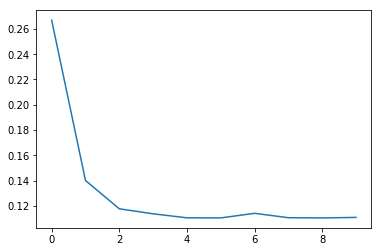

In [8]:
burnin_stats["unchanged"].plot()

In [9]:
# Burnin Stats
multiplier = 3

In [10]:
# calculate the total number of permutations
# divide the total number by half to prevent memory issues
n_perm = hetnet_df["disease_id"].nunique() * hetnet_df["gene_id"].nunique()
n_perm = int(n_perm * 0.5)

In [11]:
%%time
edges_to_prob = {x: list() for x in association_edge}

for i in tqdm.tqdm(range(n_perm)):
    pair_list, stats = permute_pair_list(pair_list, multiplier=multiplier, seed=i)
    
    pair_set = set(pair_list)
    for degree, probs in edges_to_prob.items():
        edges = association_edge[degree]
        probs.append(len(edges & pair_set) / len(edges))

100%|██████████| 361264/361264 [27:27:38<00:00,  3.65it/s]   

CPU times: user 1d 3h 26min 20s, sys: 1min 46s, total: 1d 3h 28min 7s
Wall time: 1d 3h 27min 38s


In [12]:
rows = []

for (d_deg, g_deg), probs in tqdm.tqdm(edges_to_prob.items()):
    mean = statistics.mean(probs)
    std_error = statistics.stdev(probs) / len(probs) ** 0.5
    rows.append((d_deg, g_deg, mean, std_error))
    
perm_df = pd.DataFrame(rows, columns=['disease_associates', 'gene_associates', 'prior_perm', 'prior_perm_stderr'])
perm_df.head(10)

100%|██████████| 3367/3367 [1:08:53<00:00,  1.23s/it]


,disease_associates,gene_associates,prior_perm,prior_perm_stderr
0,550,47,0.870898,0.000558
1,550,46,0.867094,0.000565
2,550,40,0.830758,0.000624
3,550,39,0.823473,0.000634
4,550,37,0.809203,0.000654
5,550,35,0.793287,0.000674
6,550,34,0.783978,0.000685
7,550,33,0.777711,0.000692
8,550,31,0.758141,0.000712
9,550,30,0.747171,0.000723


In [13]:
# Add unpermuted treatment prevalence columns
rows = list()
association_set = set(associations)

for (d_deg, g_deg), edges in association_edge.items():
    n_associations = len(edges & association_set)
    rows.append((d_deg, g_deg, n_associations, len(edges)))
degree_prior_df = pd.DataFrame(rows, columns=['disease_associates', 'gene_associates', 'n_associations', 'n_possible'])
degree_prior_df = perm_df.merge(degree_prior_df)
degree_prior_df = degree_prior_df.sort_values(['disease_associates', 'gene_associates'], ascending=False)

In [14]:
degree_prior_df.head(5)

,disease_associates,gene_associates,prior_perm,prior_perm_stderr,n_associations,n_possible
0,550,47,0.870898,0.000558,1,1
1,550,46,0.867094,0.000565,0,1
2,550,40,0.830758,0.000624,1,1
3,550,39,0.823473,0.000634,0,1
4,550,37,0.809203,0.000654,1,1


In [15]:
degree_prior_df.to_csv("degree-prior.csv", index=False, float_format='%.6g')

In [16]:
obs_pair_df = pair_df.merge(perm_df)
obs_pair_df.head(10)

,disease_id,gene_id,disease_associates,gene_associates,prior_perm,prior_perm_stderr
0,DOID:2531,7124,550,47,0.870898,0.000558
1,DOID:2531,7157,550,46,0.867094,0.000565
2,DOID:2531,5743,550,40,0.830758,0.000624
3,DOID:2531,3569,550,39,0.823473,0.000634
4,DOID:2531,4318,550,37,0.809203,0.000654
5,DOID:2531,3586,550,35,0.793287,0.000674
6,DOID:2531,7422,550,34,0.783978,0.000685
7,DOID:2531,7040,550,33,0.777711,0.000692
8,DOID:2531,3553,550,31,0.758141,0.000712
9,DOID:2531,213,550,30,0.747171,0.000723


In [17]:
obs_pair_df.to_csv("observation-prior.csv", index=False, float_format='%.6g')